In [4]:

from dotenv import load_dotenv
import os
from langchain_google_genai import ChatGoogleGenerativeAI


load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEYYY")
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",google_api_key=  GEMINI_API_KEY )


In [ ]:
from typing import Annotated, NotRequired
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

class CustomState(AgentState):
    # The user_name field in short-term state
    user_name: NotRequired[str]

@tool
def get_user_name(
    state: Annotated[CustomState, InjectedState]
) -> str:
    """Retrieve the current user-name from state."""
    # Return stored name or a default if not set
    return state.get("user_name", "Unknown user")


@tool
def update_user_name(
    new_name: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Update user-name in short-term memory."""
    return Command(update={
        "user_name": new_name,
        "messages": [
            ToolMessage(f"Updated user name to {new_name}", tool_call_id=tool_call_id)
        ]
    })

# Example agent setup
agent = create_react_agent(
    model=model,
    tools=[get_user_name],
    state_schema=CustomState,
)


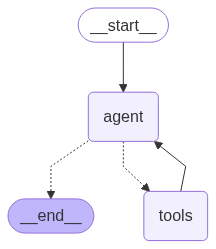

In [6]:
agent

In [7]:

# Invocation: reads the name from state (initially empty)
agent.invoke({"messages": "what's my name?"})

{'messages': [HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='20e4f7e8-c05b-4404-a2c8-06190721ccf3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_user_name', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--ef5175f1-d022-499c-8f0e-e3d4bc6b6791-0', tool_calls=[{'name': 'get_user_name', 'args': {}, 'id': 'a2029429-7fa7-4a51-bb12-3c5c39f3874b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 20, 'output_tokens': 5, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Unknown user', name='get_user_name', id='0c92719f-71c0-46c5-a9e1-0b025c35b1f1', tool_call_id='a2029429-7fa7-4a51-bb12-3c5c39f3874b'),
  AIMessage(content='I do not know your name.  The available tools did not return a name.', additional_kwargs={}, response_metadata={'prompt_f

In [ ]:
from typing import Annotated
from langgraph.prebuilt import  InjectedState
from langgraph.prebuilt.chat_agent_executor import AgentState, ToolMessage
from langchain_core.tools import tool , InjectedToolCallId
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from typing_extensions import NotRequired
from langgraph.types import Command


# --- STEP 1: Define custom memory state schema ---
class CustomState(AgentState):
    user_name: NotRequired[str]

# --- STEP 2: Tool to update user name ---
@tool
def update_user_name(
    new_name: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Update user-name in short-term memory."""
    return Command(update={
        "user_name": new_name,
        "messages": [
            ToolMessage(
                content=f"Updated user name to {new_name}",
                tool_call_id=tool_call_id
            )
        ]
    })

# --- STEP 3: Tool to fetch user name from memory ---
@tool
def get_user_name(
    state: Annotated[CustomState, InjectedState]
) -> str:
    """Return the current stored user name."""
    return state.get("user_name", "Unknown user")

# --- STEP 4: Build LangGraph agent ---
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(
    tools=[update_user_name, get_user_name],
    model=model,
    state_schema=CustomState,
    
)

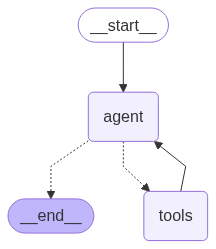

In [13]:
agent_executor

In [14]:


# --- STEP 5: Run Test Query ---
response = agent_executor.invoke({
    "messages": [HumanMessage(content="Please set my name to Shaheer.")],
    "user_name": None
})

print(response["messages"][-1].content)
print("Updated state:", response.get("user_name"))


OK. I've set your name to Shaheer. Anything else?
Updated state: Shaheer
